# Wave Packet

```
Copyright (C) 2021

Code by Leopoldo Sarra and Florian Marquardt
Max Planck Institute for the Science of Light, Erlangen, Germany
http://www.mpl.mpg.de

This work is licensed under the Creative Commons Attribution 4.0 International License. To view a copy of this license, visit http://creativecommons.org/licenses/by/4.0/ or send a letter to Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

If you find this code useful in your work, please cite our article
"Renormalized Mutual Information for Artificial Scientific Discovery", Leopoldo Sarra, Andrea Aiello, Florian Marquardt, arXiv:2005.01912

available on

https://arxiv.org/abs/2005.01912
```


We extract a one dimensional feature given a 1D fluctuating field (with 100 components).
The field is composed by the superposition of 
- uncorrelated Gaussian background noise
- a fixed shape at a random position jbar, which is chosen randomly between [30,70]

We compare the obtained feature with several different alternatives

In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt

import rmi.neuralnets as nn
import rmi.estimation as inf
import rmi.features as f

import rmi.examples.wavepacket as wp
from rmi.pca import pca as PCA

from tqdm import tqdm, trange

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

## Neural Network feature extraction

In [2]:
# Define the wave packet
n_in = 100
n_out = 1

noise = 0.7
width = 9.0
pos_range = [30,70]

# Function to sample wave packet configurations
get_batch = lambda N_batch: wp.produce_Wave_Packet(n_pixels=n_in,
                                 n_samples=N_batch,
                                 width=width,
                                 noise=noise,
                                 pos_range=pos_range)

In [3]:
# Number of neurons in each layer of the network
n_neurons = 70

# Options to estimate the entropy H(y)
# Number of bins
H_nbins = 180

# Size of the kernel placed on each point
# to make the histogram differentiable
# (in units of the histogram-cell-width)
H_kernel_size = 1


# Strength of the constraint on the output distribution
# of the feature (exploiting reparametrization invariance)
coeff_gauss = 5

# Amplitude of the regularization to encourage
# feature smoothness (amplitude e^{-n/decay})
reg_amplitude = 100

# Decay time of the regularizing term
reg_decay = 1000

N_train = 15000
batchsize = 700
eta = 0.0005

In [4]:
# Define the layout of the neural network
# The cost function is implicit when choosing the model RMIOptimizer
rmi_optimizer = nn.RMIOptimizer(H_nbins,
                                H_kernel_size,
                                coeff_gauss,
                                reg_amplitude=reg_amplitude,
                                reg_decay=reg_decay,
                                layers=[
    nn.K.layers.Dense(n_neurons, activation="tanh",
                  input_shape=(n_in,)),
    nn.K.layers.Dense(n_neurons, activation="tanh"),
    nn.K.layers.Dense(n_out)
])

# Compile the network === choose the optimizer to use during the training
rmi_optimizer.compile(optimizer=nn.tf.optimizers.Adam(eta))

# Define an objects that handles the training and 
# automatically saves the model and the training history
rmi_net = nn.Net(rmi_optimizer,
                 path="models/wavepacket-rmi",
                 mode="a")

Loaded neural network weights from models/wavepacket-rmi


In [7]:
# Perform the training of the neural network
rmi_net.fit_generator(lambda: get_batch(batchsize)[0], N_train)

Model already trained, skipping training.


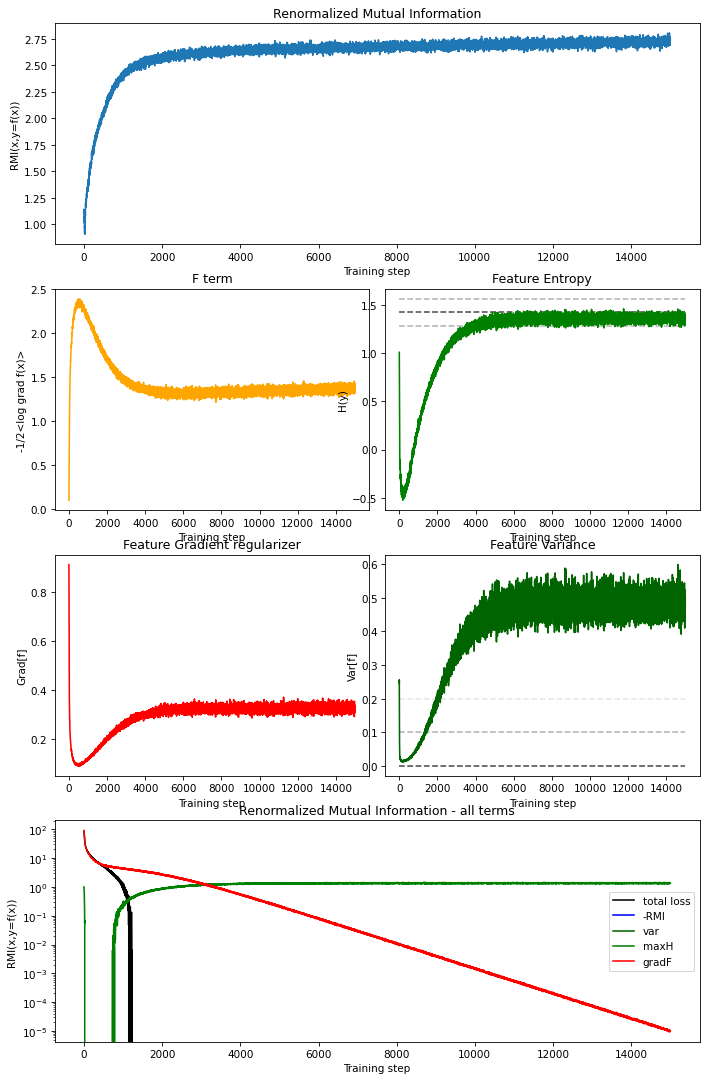

In [8]:
# Plot the training history (and other useful quantities)
rmi_net.plot_rmi_cost()

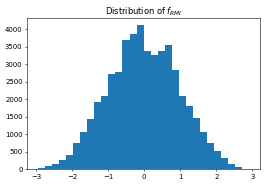

In [9]:
# Plot the distribution of the extracted feature
plt.figure(dpi=50)
plt.title("Distribution of $f_{RMI}$")
samples = get_batch(50000)
plt.hist(rmi_optimizer(samples).numpy(),30)
plt.show()

### Visualize the extracted feature

In [10]:
# Sample wave packet configurations
samples, last_pos = get_batch(30000)

# Calculate feature
f_nn = rmi_net.get_feature_and_grad(samples)

# Print Renormalized mutual information
print(inf.RenormalizedMutualInformation(*f_nn))

2.780913220694179


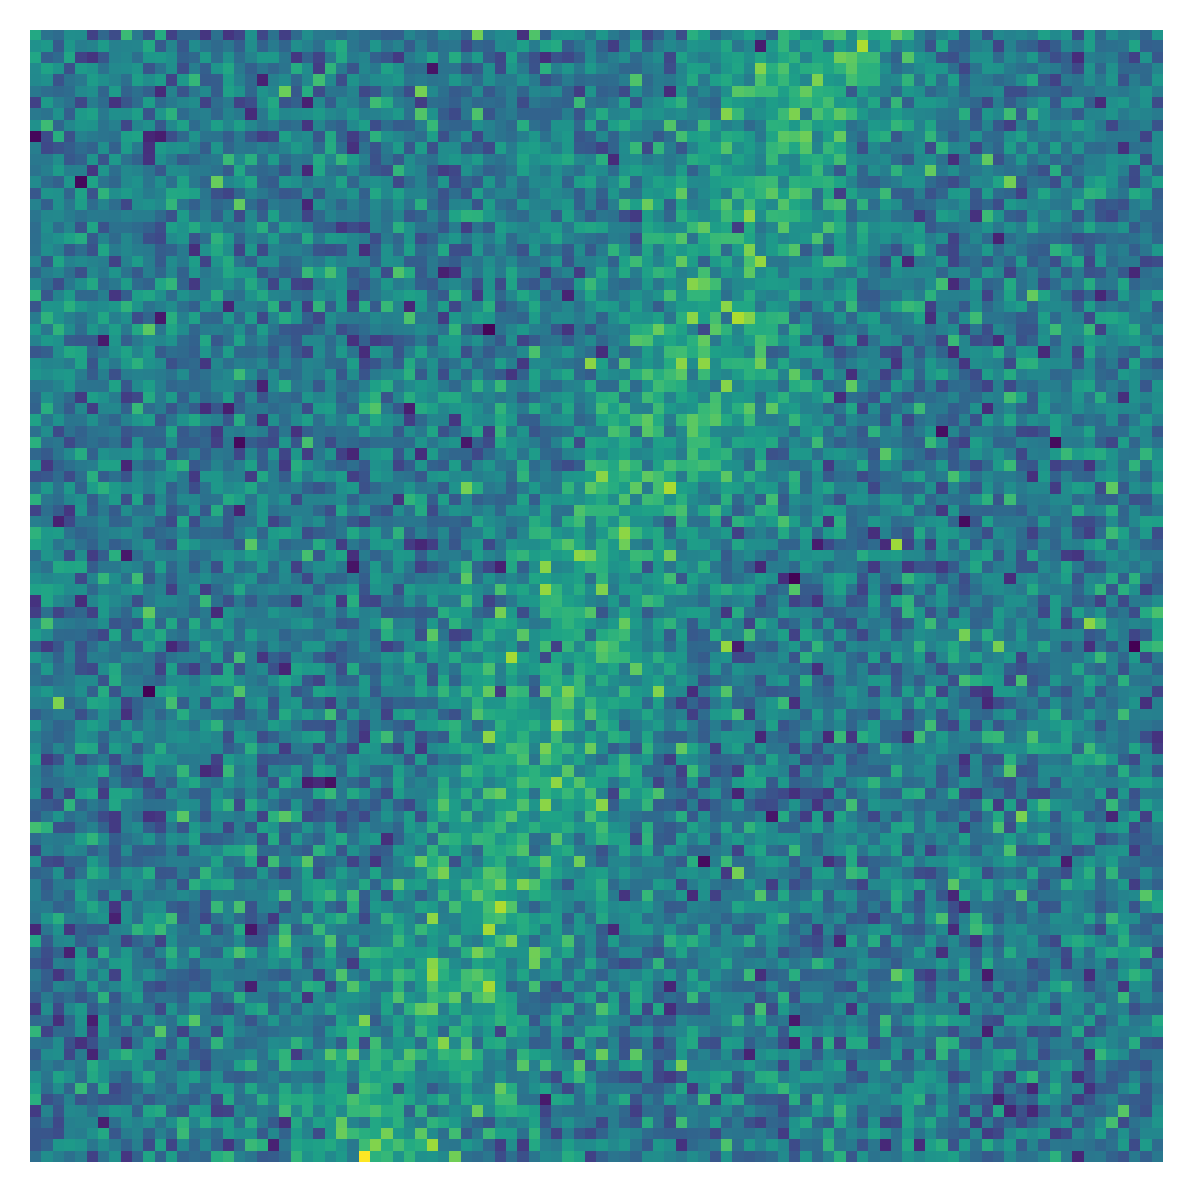

In [11]:
wp.plot_sorted_feature(samples, f_nn[0], save_path="figures/wp_comp_nn")

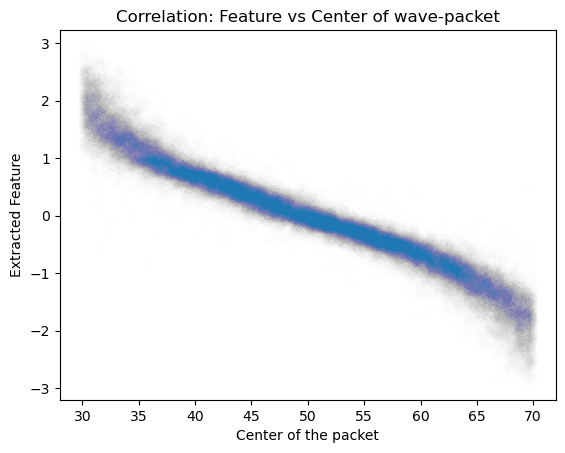

In [14]:
plt.figure()
plt.title("Correlation: Feature vs Center of wave-packet")
plt.xlabel("Center of the packet")
plt.ylabel("Extracted Feature")
plt.scatter(last_pos, f_nn[0], alpha=0.005)
plt.show()

## Autoencoder

Train a contractive autoencoder to reconstruct the input
The bottleneck is considered as the extracted feature
We use a `nn.RMIOptimizer` model to be able to quickly evaluate
the RMI of the feature


In [50]:
# Encoder
encoder = nn.RMIOptimizer(H_nbins,
                          H_kernel_size, layers=[
    nn.K.layers.Dense(n_neurons, activation="tanh",
                  input_shape=(n_in,)),
    nn.K.layers.Dense(n_neurons, activation="tanh"),
    nn.K.layers.Dense(n_out)
])
enc_net = nn.Net(encoder)

# Decoder
decoder = nn.K.Sequential(layers=[
    nn.K.layers.Dense(n_neurons, activation="relu",
                  input_shape=(n_out,)),
    nn.K.layers.Dense(n_neurons, activation="relu"),
    nn.K.layers.Dense(n_in)
])

# Autoencoder
autoencoder = nn.Supervised(cost="mse_contract", layers=[encoder, decoder])
autoencoder.compile(optimizer=nn.tf.optimizers.Adam(eta))

ae_net = nn.Net(autoencoder, 
                path="models/wavepacket-ae",
                mode="a")



Loaded neural network weights from models/wavepacket-ae


In [51]:
ae_net.fit_generator(lambda: get_batch(batchsize)[0], N_train)

Model already trained, skipping training.


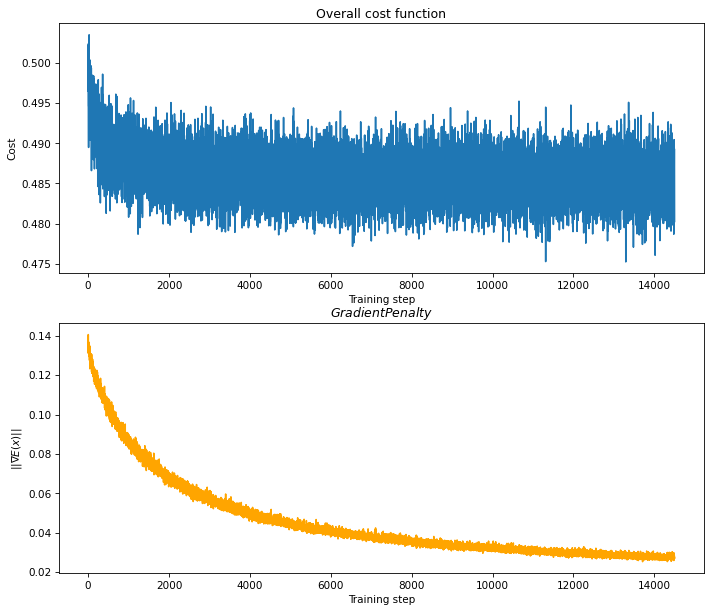

In [52]:
ae_net.plot_mse_contractive_costs(500)

### Extracted feature
It reconstructs a "denoisied" version of the input field

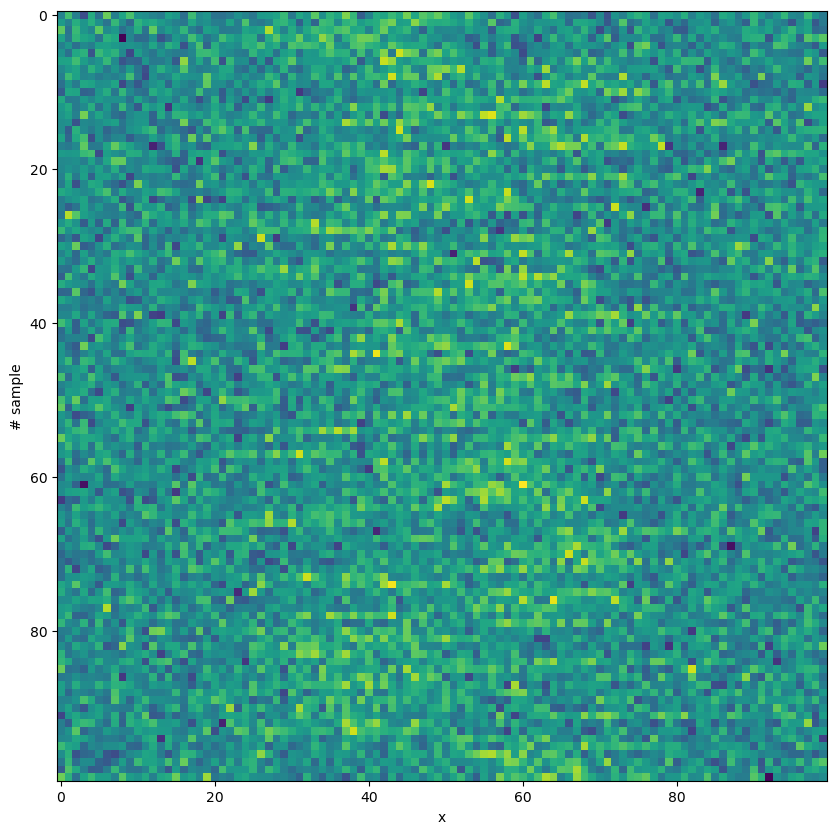

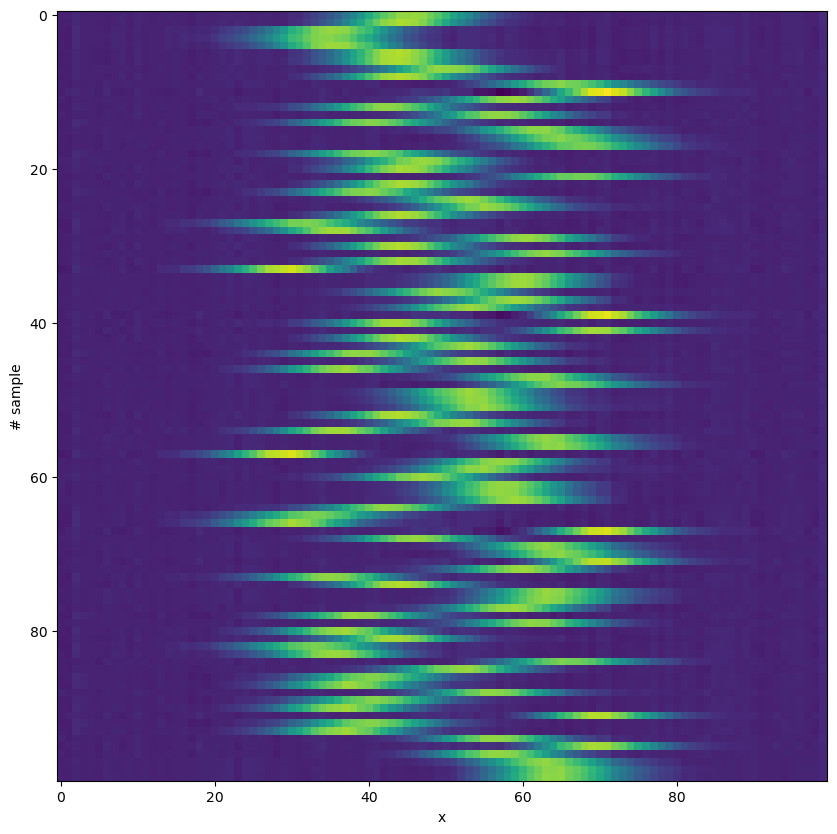

In [39]:
x_batch =get_batch(200)[0]
y_batch = autoencoder.predict_on_batch(x_batch)
wp.plot(x_batch)
wp.plot(y_batch)

---
## Compare different features
We compare the different features in different regimes, according to the strength of the background noise

A different neural network should be trained for each different noise value 
(one can run it through a script and use the following code to analyze the results)

In [14]:
# range of background noise std.
# (The amplitude of the wave packet is fixed to 1)
n_linsp = np.linspace(0.1,1.,20)

In [7]:
outputs = []
for i in trange(len(n_linsp)):
    samples = wp.produce_Wave_Packet(n_pixels=n_in,
                                     n_samples=100000,
                                     width=width,
                                     noise=n_linsp[i],
                                     pos_range=pos_range)[0]
    
    # Comment this line to always use the same model
    # (previously trained in this notebook)
    # instead of using a different neural network 
    # for each noise value
    try:
        rmi_net.load("models/wavepacket_noise_" + str(i) )
        ae_net.load("models/wavepacket_ae_noise_" + str(i) )
    except Exception:
        print(str(i) + " not found")

    
    minf = inf.print_feature_batch(samples,
                        [f.pca,  f.sum_x, f.sum_x_j,rmi_net.get_feature_and_grad , f.qm_j,
                         f.sum_x2_j, enc_net.get_feature_and_grad], 
                        [ "PCA",  r"$\sum x_i$"  ,r"$\sum i x_i$", "NN", "<x|j|x>", 
                         r"$\sum i x_i^2$", "AE"],
                        is_printing=False);
    outputs.append(np.array(minf))
    
outputs_array = np.array(outputs)

  0%|          | 0/20 [00:00<?, ?it/s]

Loaded neural network weights from models/wavepacket_noise_0
Loaded neural network weights from models/wavepacket_ae_noise_0


  5%|▌         | 1/20 [00:03<00:57,  3.04s/it]

Loaded neural network weights from models/wavepacket_noise_1
Loaded neural network weights from models/wavepacket_ae_noise_1


 10%|█         | 2/20 [00:05<00:44,  2.46s/it]

Loaded neural network weights from models/wavepacket_noise_2
Loaded neural network weights from models/wavepacket_ae_noise_2


 15%|█▌        | 3/20 [00:07<00:38,  2.28s/it]

Loaded neural network weights from models/wavepacket_noise_3
Loaded neural network weights from models/wavepacket_ae_noise_3


 20%|██        | 4/20 [00:09<00:35,  2.22s/it]

Loaded neural network weights from models/wavepacket_noise_4
Loaded neural network weights from models/wavepacket_ae_noise_4


 25%|██▌       | 5/20 [00:11<00:34,  2.31s/it]

Loaded neural network weights from models/wavepacket_noise_5
Loaded neural network weights from models/wavepacket_ae_noise_5


 30%|███       | 6/20 [00:14<00:33,  2.37s/it]

Loaded neural network weights from models/wavepacket_noise_6
Loaded neural network weights from models/wavepacket_ae_noise_6


 35%|███▌      | 7/20 [00:16<00:29,  2.29s/it]

Loaded neural network weights from models/wavepacket_noise_7
Loaded neural network weights from models/wavepacket_ae_noise_7


 40%|████      | 8/20 [00:18<00:26,  2.21s/it]

Loaded neural network weights from models/wavepacket_noise_8
Loaded neural network weights from models/wavepacket_ae_noise_8


 45%|████▌     | 9/20 [00:20<00:25,  2.29s/it]

Loaded neural network weights from models/wavepacket_noise_9
Loaded neural network weights from models/wavepacket_ae_noise_9


 50%|█████     | 10/20 [00:23<00:23,  2.37s/it]

Loaded neural network weights from models/wavepacket_noise_10
Loaded neural network weights from models/wavepacket_ae_noise_10


 55%|█████▌    | 11/20 [00:25<00:20,  2.27s/it]

Loaded neural network weights from models/wavepacket_noise_11
Loaded neural network weights from models/wavepacket_ae_noise_11


 60%|██████    | 12/20 [00:27<00:17,  2.20s/it]

Loaded neural network weights from models/wavepacket_noise_12
Loaded neural network weights from models/wavepacket_ae_noise_12


 65%|██████▌   | 13/20 [00:29<00:15,  2.17s/it]

Loaded neural network weights from models/wavepacket_noise_13
Loaded neural network weights from models/wavepacket_ae_noise_13


 70%|███████   | 14/20 [00:31<00:12,  2.13s/it]

Loaded neural network weights from models/wavepacket_noise_14
Loaded neural network weights from models/wavepacket_ae_noise_14


 75%|███████▌  | 15/20 [00:33<00:10,  2.11s/it]

Loaded neural network weights from models/wavepacket_noise_15
Loaded neural network weights from models/wavepacket_ae_noise_15


 80%|████████  | 16/20 [00:35<00:08,  2.11s/it]

Loaded neural network weights from models/wavepacket_noise_16
Loaded neural network weights from models/wavepacket_ae_noise_16


 85%|████████▌ | 17/20 [00:37<00:06,  2.08s/it]

Loaded neural network weights from models/wavepacket_noise_17
Loaded neural network weights from models/wavepacket_ae_noise_17


 90%|█████████ | 18/20 [00:39<00:04,  2.07s/it]

Loaded neural network weights from models/wavepacket_noise_18
Loaded neural network weights from models/wavepacket_ae_noise_18


 95%|█████████▌| 19/20 [00:41<00:02,  2.08s/it]

Loaded neural network weights from models/wavepacket_noise_19
Loaded neural network weights from models/wavepacket_ae_noise_19


100%|██████████| 20/20 [00:44<00:00,  2.20s/it]


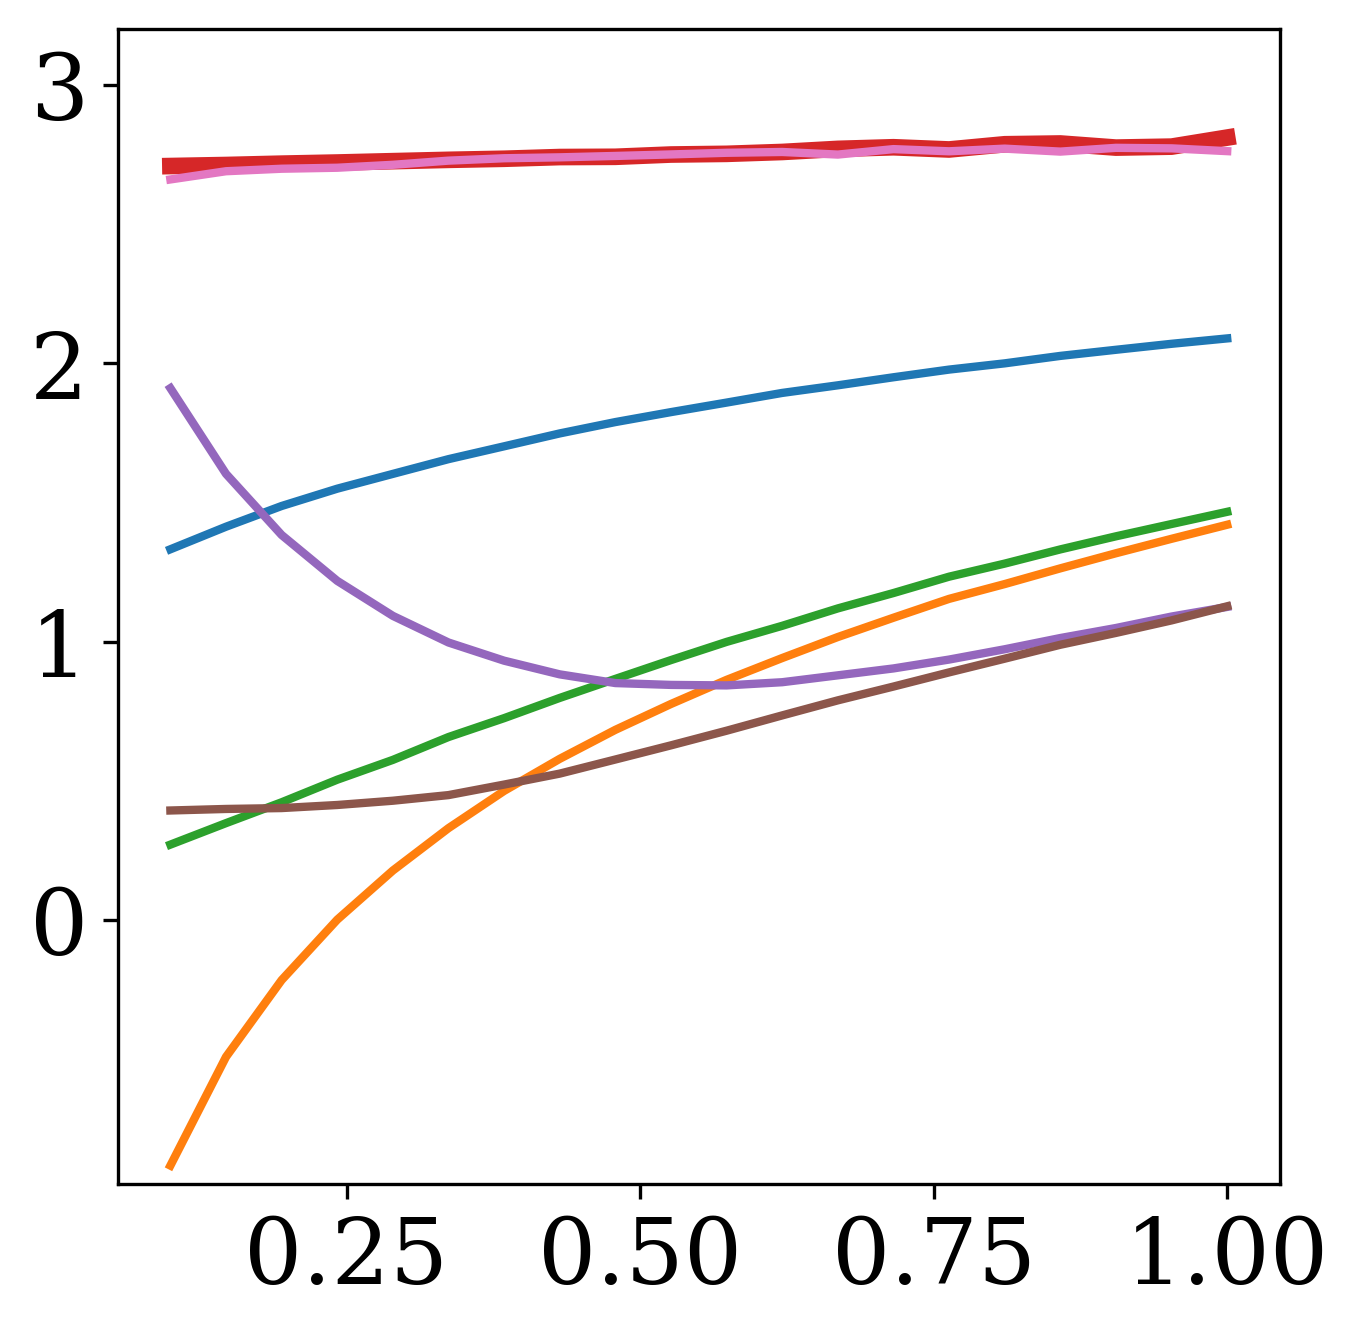

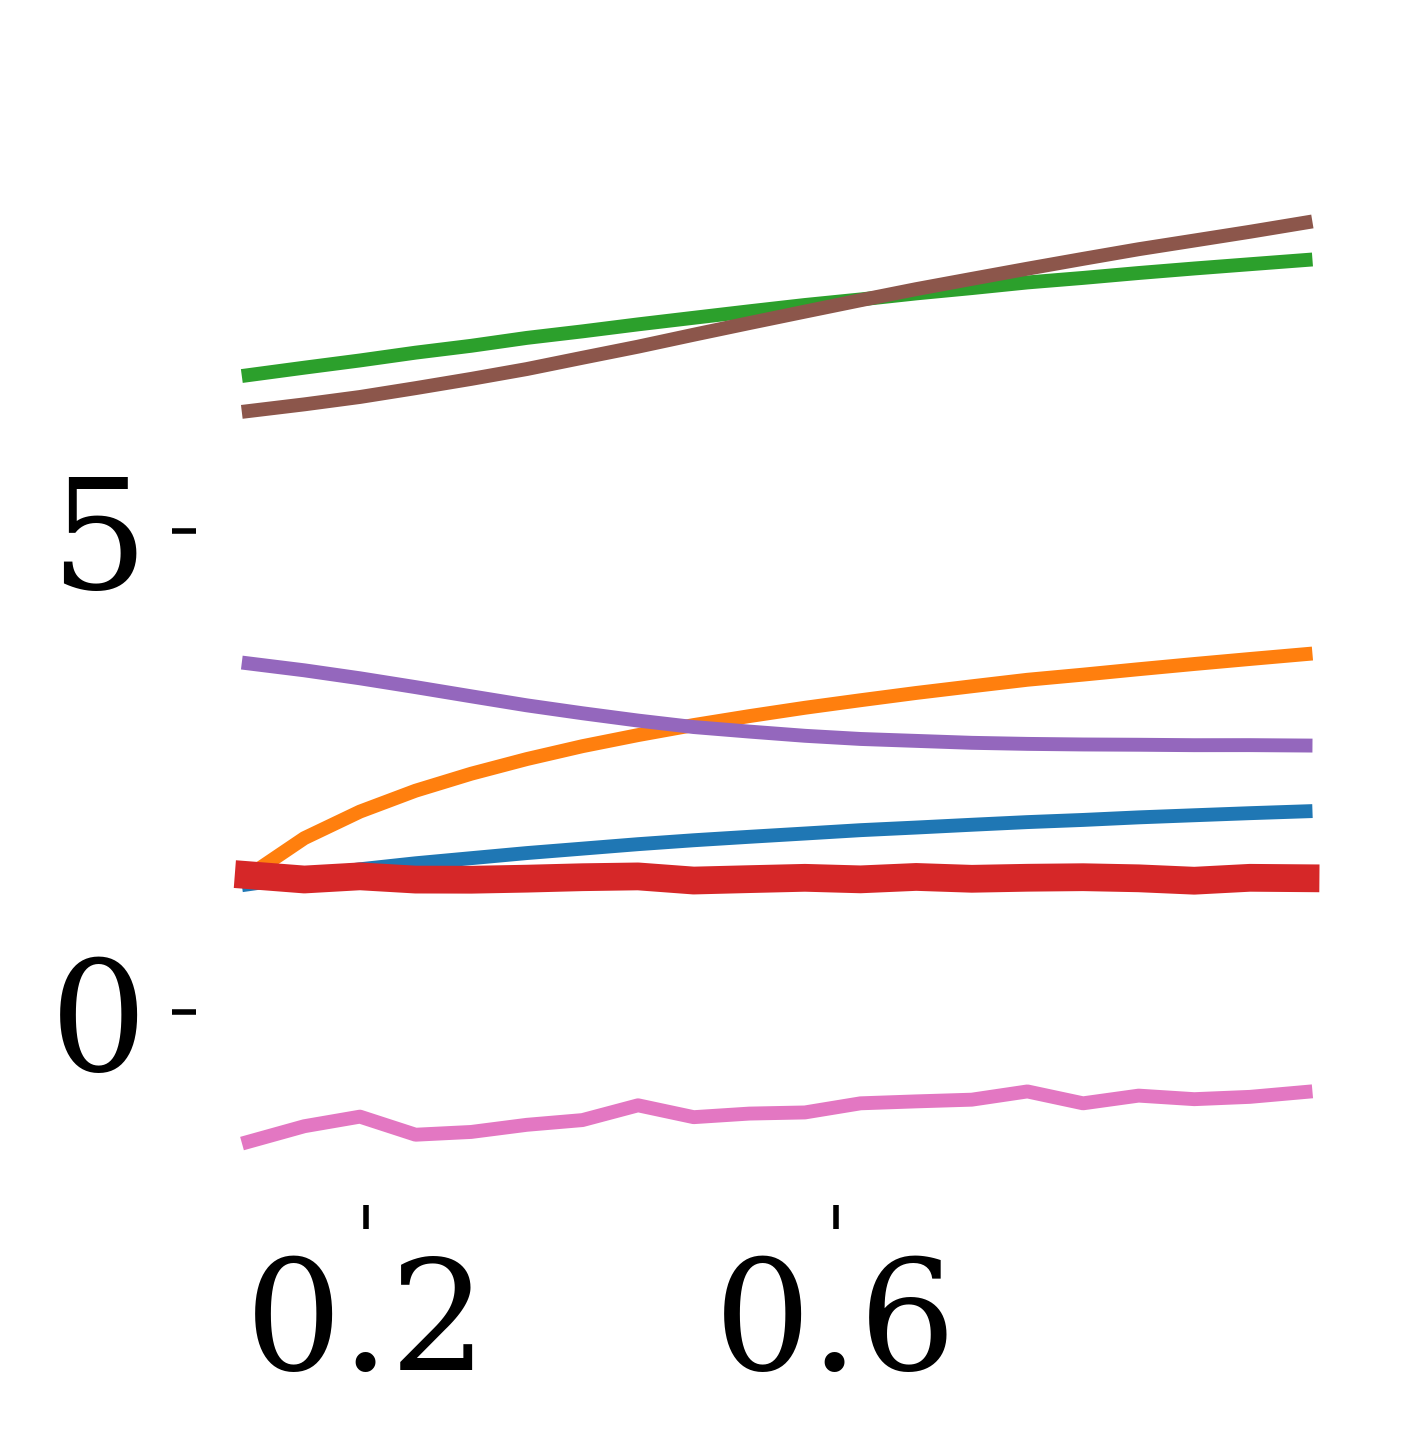

In [53]:
# Plot the RMI values vs noise strength for different features
# Legend is disabled when saving the plot 
# Just to generate the plots for the paper
inf.plot_feature_batch(n_linsp,outputs_array,
                       ylims=np.array([[-0.95,3.2],[-2,10]]),
                       fig="figures/wp_rmi", 
                       save=True)

### Visually compare different features


Noise =  0.38421052631578945
Loaded neural network weights from models/wavepacket_noise_6
Loaded neural network weights from models/wavepacket_ae_noise_6
Neural Network


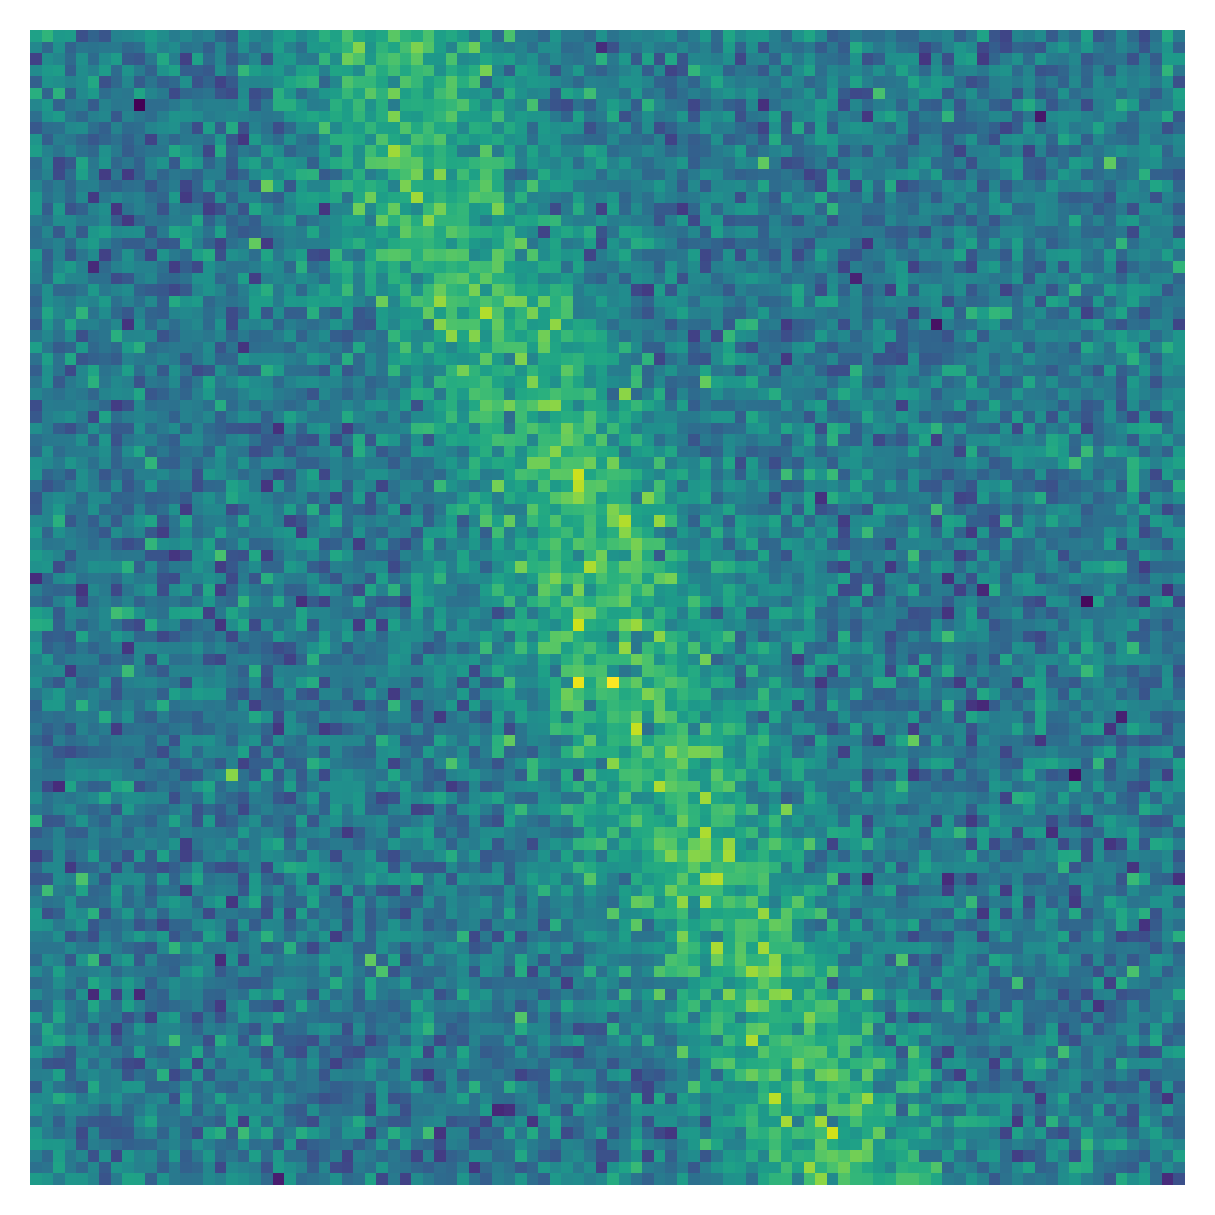

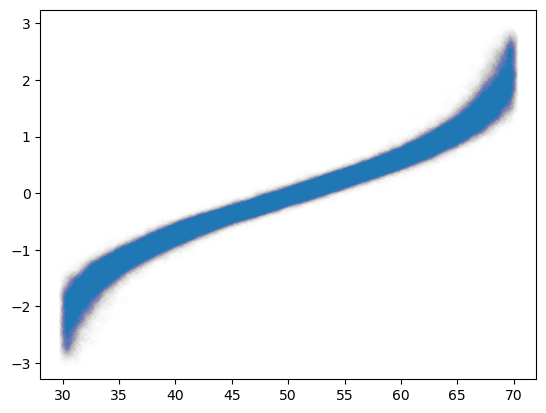

Pca


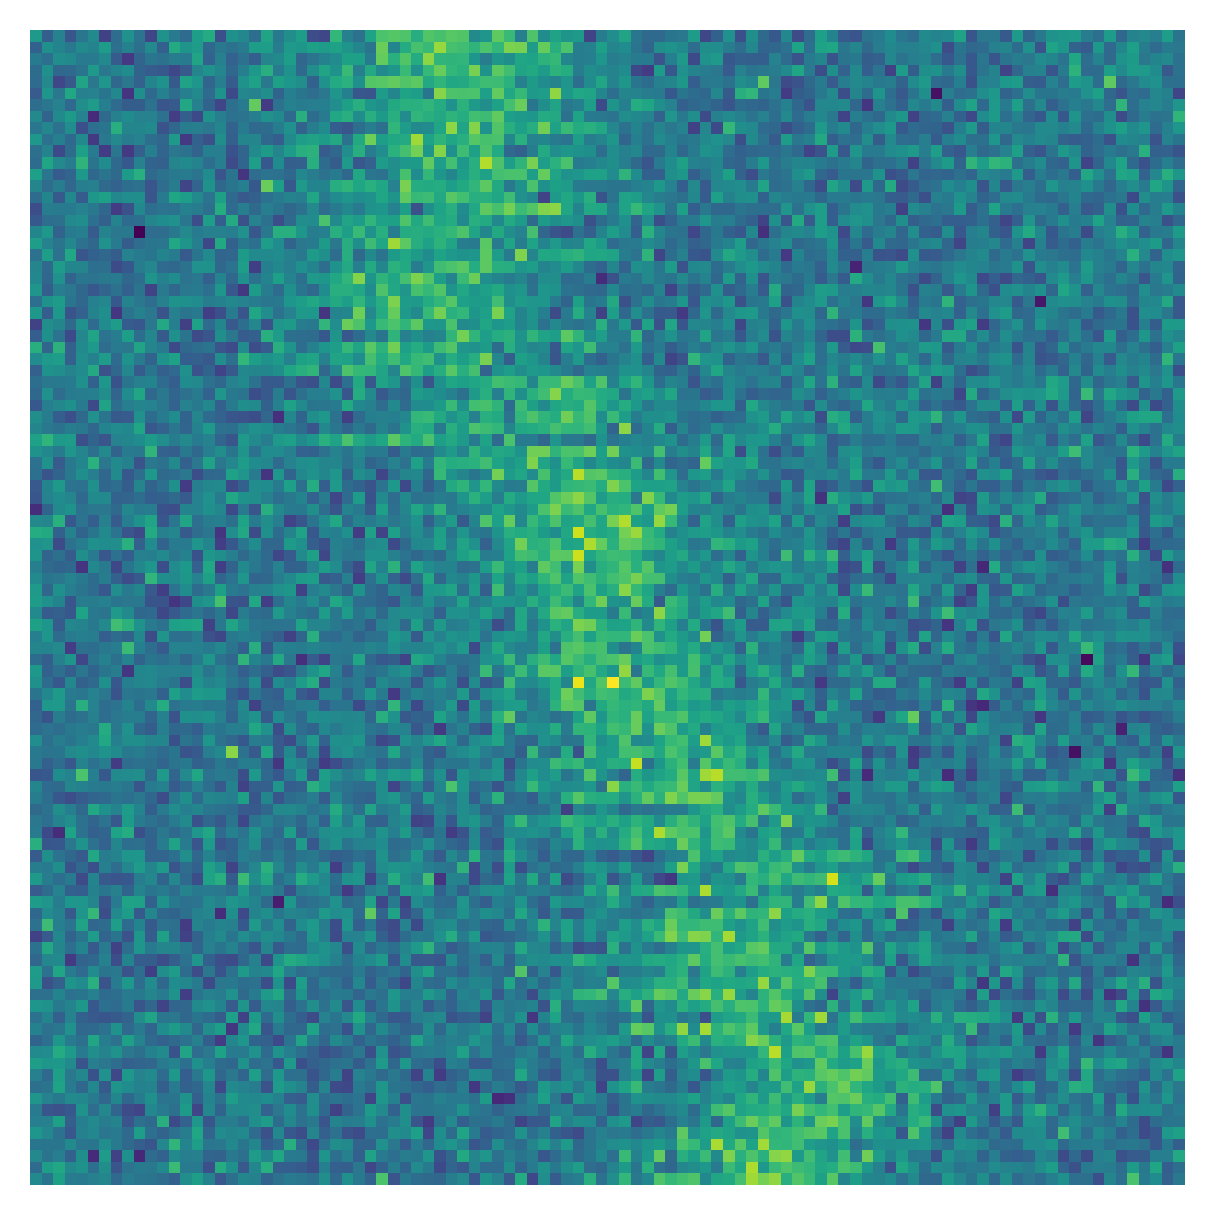

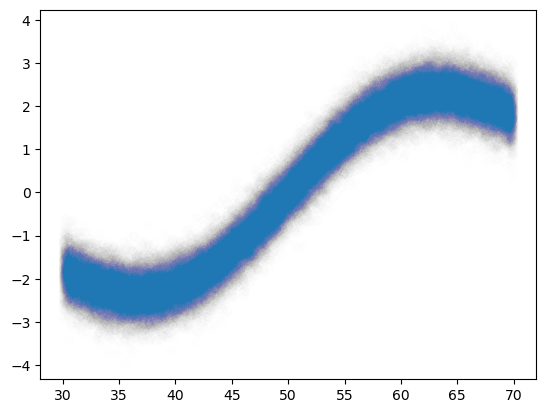

F_QM


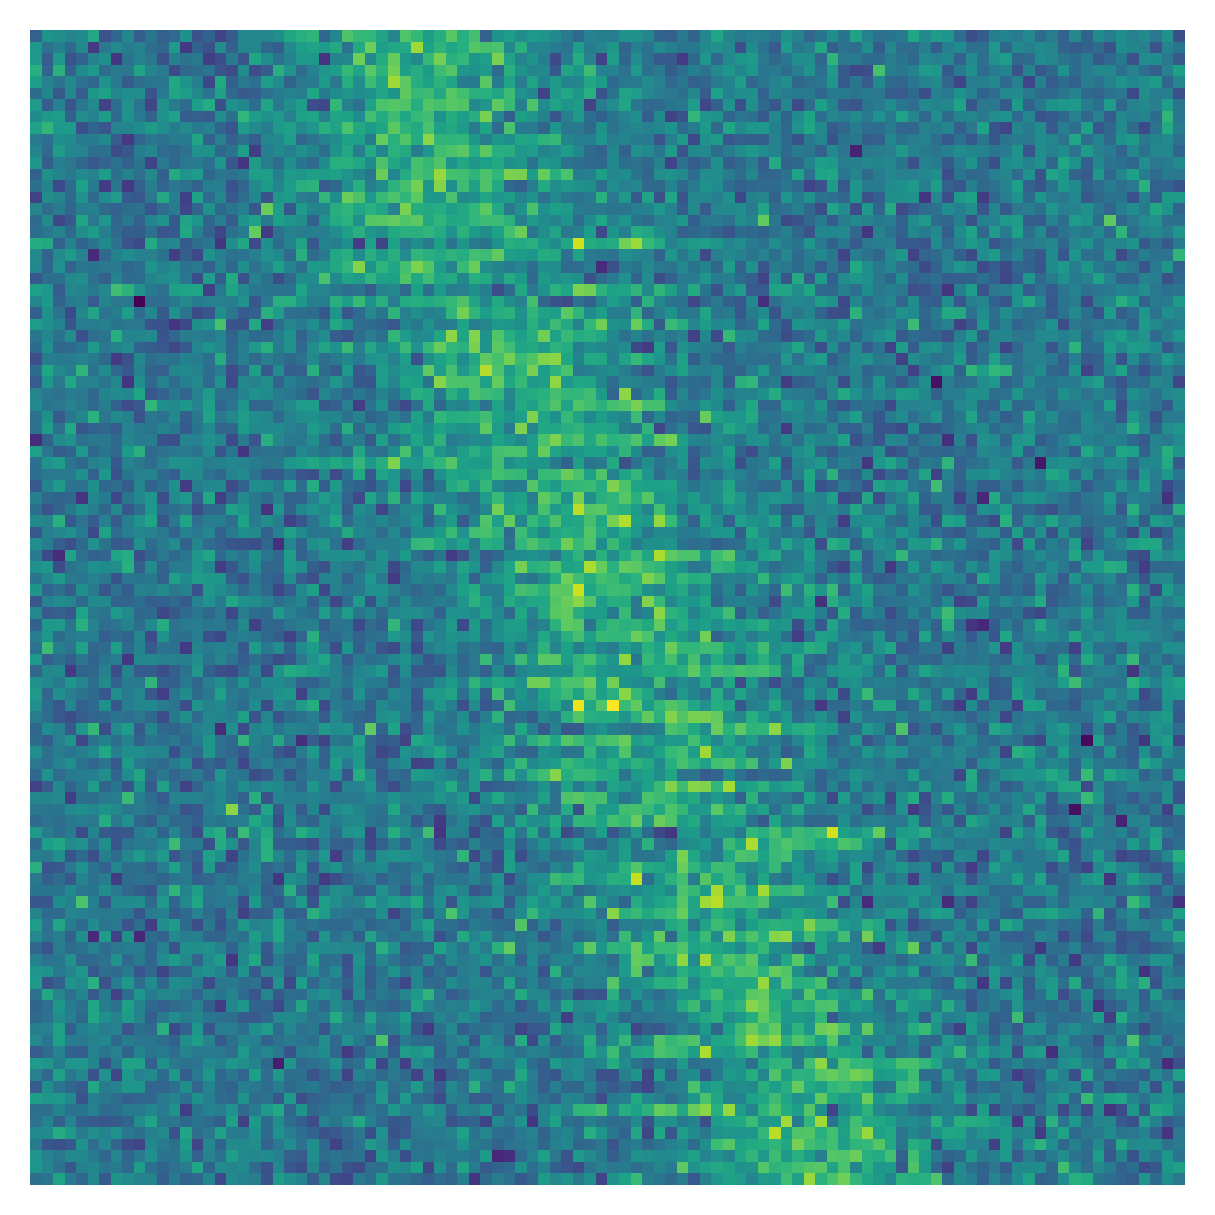

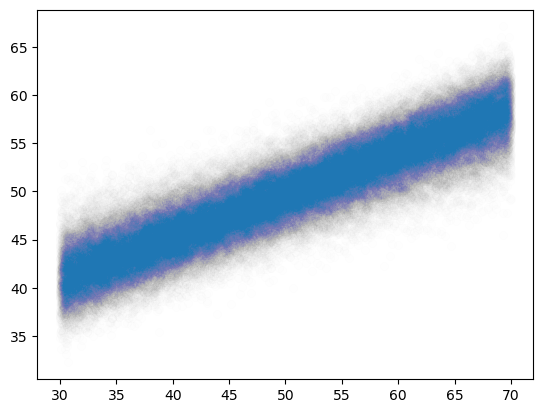

F_X2


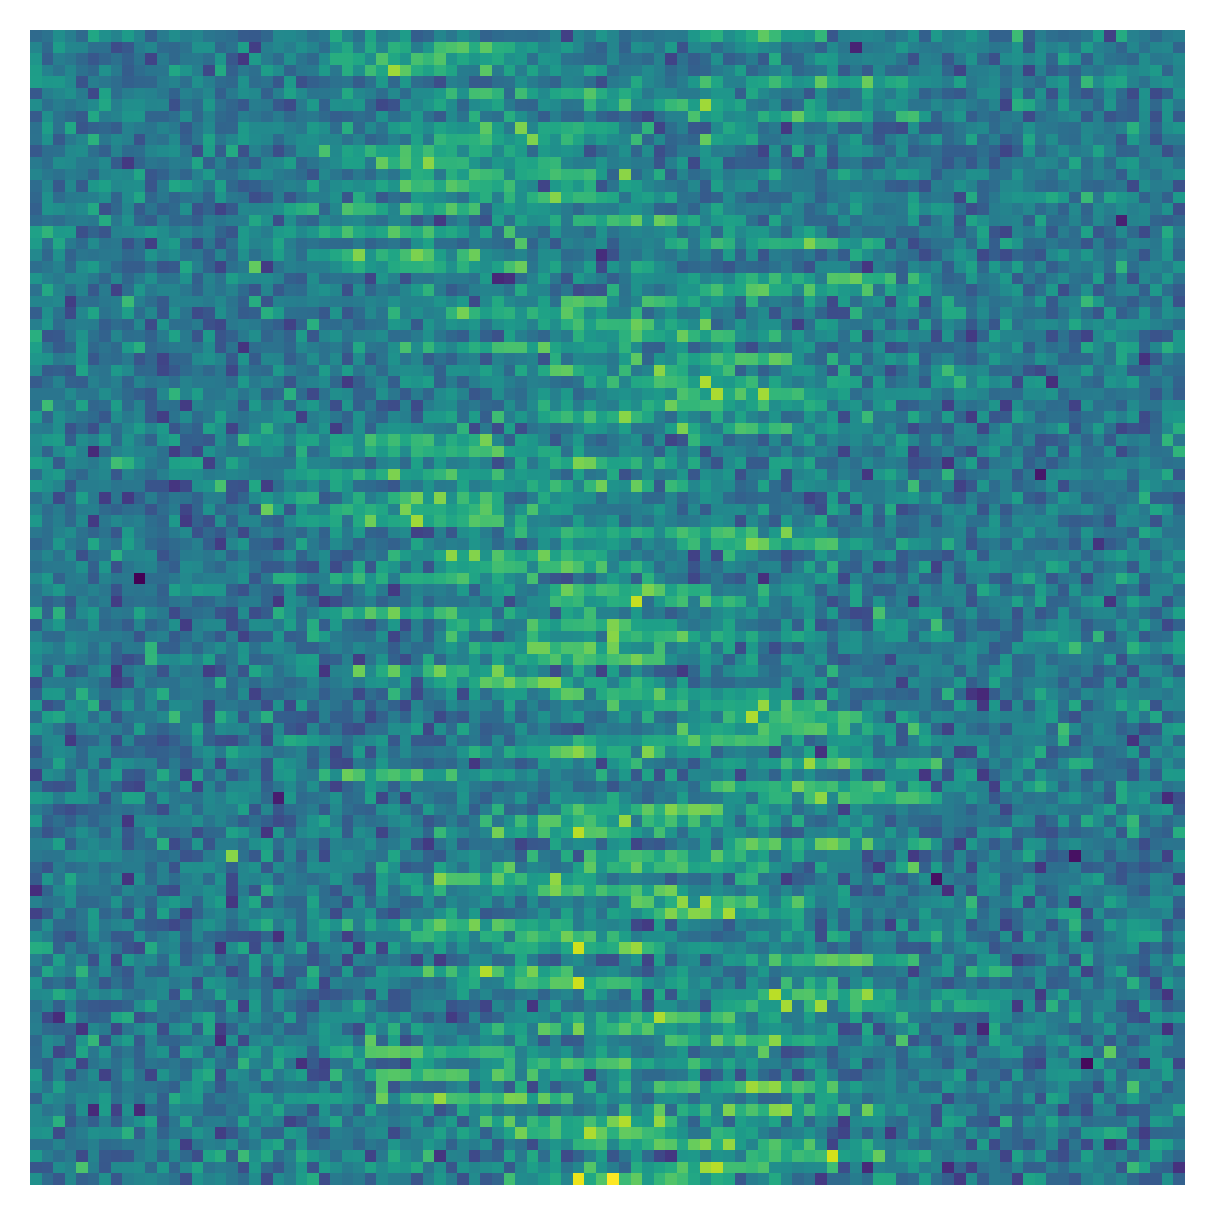

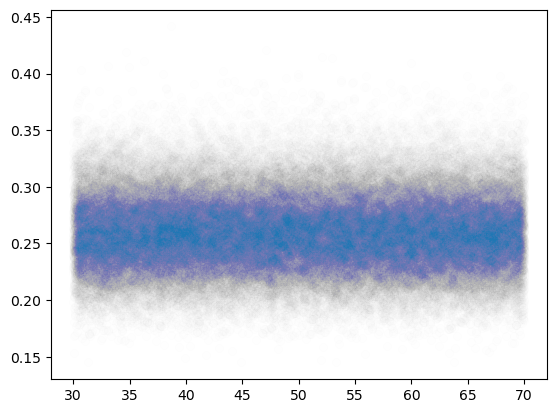

F_AUTOENCODER


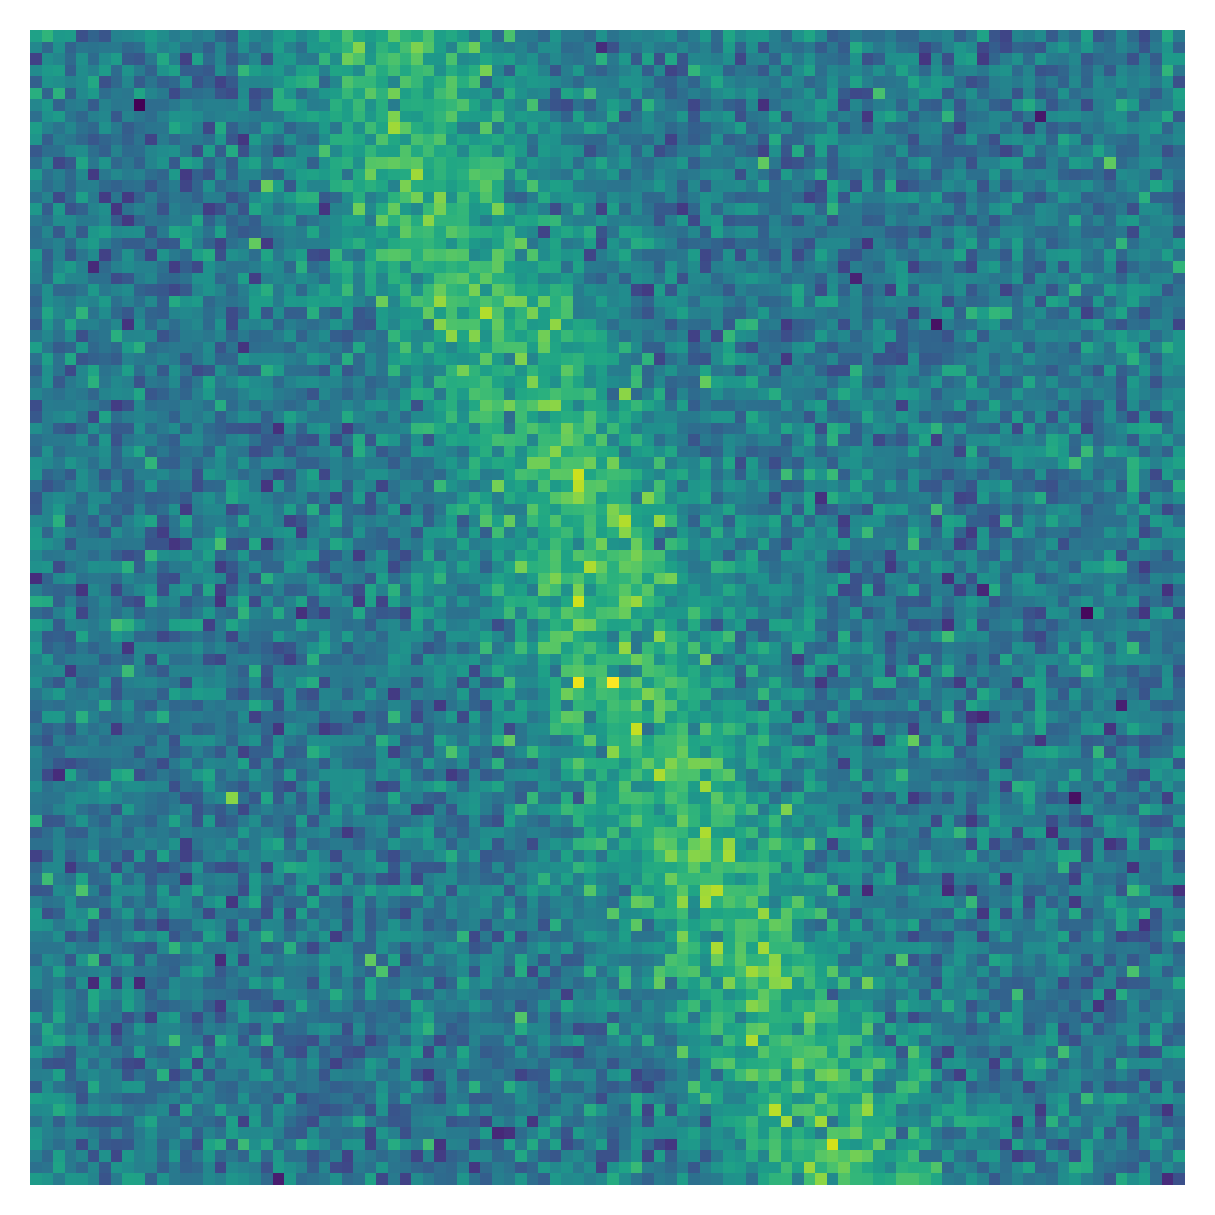

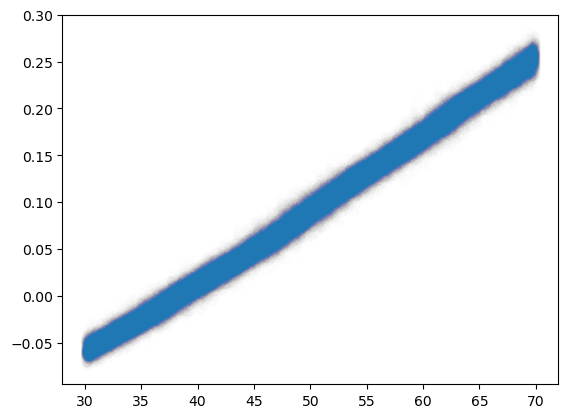

In [65]:
calculated_rmis = {}
chosen_noise = 6
print("Noise = ", n_linsp[chosen_noise])

rmi_net.load("models/wavepacket_noise_%d" % chosen_noise )
ae_net.load("models/wavepacket_ae_noise_%d" % chosen_noise)

samples, last_pos = wp.produce_Wave_Packet(n_pixels=n_in,n_samples=90000,width=width,noise=n_linsp[chosen_noise],pos_range=pos_range)

# f_x2j = f.sum_x2_j(samples)
print("Neural Network")
f_nn = rmi_net.get_feature_and_grad(samples)
wp.plot_sorted_feature(samples, f_nn[0],"figures/wp_comp_nn")
plt.scatter(last_pos, f_nn[0], alpha=0.005)
plt.show()
calculated_rmis["nn"] = inf.RenormalizedMutualInformation(*f_nn)



print("Pca")
f_pca = f.pca(samples)
wp.plot_sorted_feature(samples, f_pca[0], "figures/wp_comp_pca")
plt.scatter(last_pos, f_pca[0], alpha=0.005)
plt.show()
calculated_rmis["pca"] = inf.RenormalizedMutualInformation(*f_pca)


print("F_QM")
f_qm = f.qm_j(samples)
wp.plot_sorted_feature(samples, f_qm[0][:,None], "figures/wp_comp_qm")
plt.scatter(last_pos, f_qm[0], alpha=0.005)
plt.show()
calculated_rmis["qm"] = inf.RenormalizedMutualInformation(*f_qm)


print("F_X2")
f_x2 = f.x2(samples)
wp.plot_sorted_feature(samples, f_x2[0][:,None], "figures/wp_comp_x2")
plt.scatter(last_pos, f_x2[0], alpha=0.005)
plt.show()
calculated_rmis["x2"] = inf.RenormalizedMutualInformation(*f_x2)


print("F_AUTOENCODER")
f_ae = enc_net.get_feature_and_grad(samples)
wp.plot_sorted_feature(samples, f_ae[0], "figures/wp_comp_ae")
plt.scatter(last_pos, f_ae[0], alpha=0.005)
plt.show()
calculated_rmis["ae"] = inf.RenormalizedMutualInformation(*f_ae)

In [41]:
# Print summary table
def format_bar(val,max_val=calculated_rmis["nn"],length=18):
    return "{empty:#^{val}}".format(empty="",val=int(val/max_val*length))

print("")
print("\t|{:-^45}|".format(""))
print("\t|{:^45}|".format(" Renormalized Mutual Information "))
print("\t|{:=^45}|".format(""))
print("\t|{:>15}{:^12.2f}{:.<18}|".format("NN:", calculated_rmis["nn"],format_bar(calculated_rmis["nn"])))
print("\t|{:>15}{:^12.2f}{:.<18}|".format("PCA:", calculated_rmis["pca"],format_bar(calculated_rmis["pca"])))
print("\t|{:>15}{:^12.2f}{:.<18}|".format("QM:", calculated_rmis["qm"],format_bar(calculated_rmis["qm"])))
print("\t|{:>15}{:^12.2f}{:.<18}|".format("X2:", calculated_rmis["x2"],format_bar(calculated_rmis["x2"])))
print("\t|{:>15}{:^12.2f}{:.<18}|".format("AE:", calculated_rmis["ae"],format_bar(calculated_rmis["ae"])))
print("\t|{:-^45}|".format(""))
print("")



	|---------------------------------------------|
	|       Renormalized Mutual Information       |
	|=============================================|
	|            NN:    2.74    ##################|
	|           PCA:    1.71    ###########.......|
	|            QM:    0.93    ######............|
	|            X2:    0.29    #.................|
	|            AE:    2.74    ##################|
	|---------------------------------------------|



---
## Supervised task starting from the feature representation

In [7]:
neurons_supervised = 50
eta_supervised = 0.001
batchsize_supervised = 200
N_train_supervised = 10000

In [19]:
get_batch = lambda N_batch: wp.produce_Wave_Packet(n_pixels=n_in,
                                 n_samples=N_batch,
                                 width=width,
                                 noise=n_linsp[chosen_noise],
                                 pos_range=pos_range)


def get_superv_batch(batchsize, feat_function):
    """Get batch to train a supervised network

    It assumes the existence of the `get_batch` function

    Args:
        batchsize (int): number of samples to generate
        feat_function (function): function to calculate the feature and its gradient

    Returns:
        feature (array_like): [batchsize, 1] input of the network
        last_pos (array_like): [batchsize, 1] label for supervised training
    """

    # Generate samples
    x_batch, last_pos = get_batch(batchsize)
    
    # Calculate feature
    feature_batch = feat_function(x_batch)[0]
    # Fixes shape to proper output [batchsize, 1]
    if len(feature_batch.shape)==1: feature_batch = feature_batch[:,None]
    
    return feature_batch, last_pos[:,None]

def new_supervised_net(n_neurons, eta):
    """Initialize a new neural network

    Args:
        n_neurons (int): number of neurons
        eta (float): learning rate

    Returns:
        nn.K.Model: neural network model
    """
    net = nn.Supervised(cost="mse",
        layers=[
        nn.K.layers.Dense(n_neurons, activation="relu",
                      input_shape=(1,)),
        nn.K.layers.Dense(n_neurons, activation="relu"),
        nn.K.layers.Dense(1)
    ])
    net.compile(optimizer = nn.tf.optimizers.Adam(eta))
    return net

def superv_show_perf(sup_net, feature_funct, history):
    """Plot result of supervised training of a network

    Args:
        sup_net (nn.K.model): neural network (for supervised task)
        feature_funct (function): (samples) => (feature, grad_feature) function that calculated the feature and its gradient of a given set of samples
        history (array_like): history of the training (to plot it automatically)
    """
    plt.plot(history[2000:])
    
    # Get batch
    x_batch, last_pos = get_batch(1000)
    
    # Calculate feature
    feature_batch = feature_funct(x_batch)[0]
    
    # Supervised network prediction
    supervised_batch = sup_net(feature_batch).numpy()

    plt.figure()
    plt.title("Comparison")
    plt.xlabel("Center of the packet")
    plt.ylabel("Supervised Network prediction")
    plt.scatter(last_pos,supervised_batch,alpha=0.3, s=8)
    plt.gca().set_aspect("equal")

    print(history[-1])

### Neural Network feature

In [44]:
supervised_rmi = new_supervised_net(neurons_supervised, eta_supervised)
s_rmi_net = nn.Net(supervised_rmi,
                   mode="a",
                   path = "models/wavepacket-sup-rmi")

Loaded neural network weights from models/wavepacket-sup-rmi


In [45]:
s_rmi_net.fit_generator(lambda: get_superv_batch(batchsize_supervised, rmi_net.get_feature_and_grad), N_train_supervised)

Model already trained, skipping training.


[1.0516085624694824]


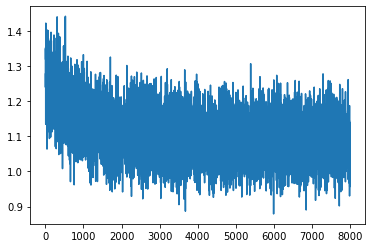

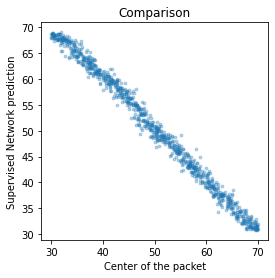

In [22]:
superv_show_perf(supervised_rmi, rmi_net.get_feature_and_grad, s_rmi_net.history)

### Handcrafted feature
$$
f_{QM} = \frac{\sum j x_j^2}{\sum x_i^2}
$$

In [73]:
supervised_qm = new_supervised_net(neurons_supervised, eta_supervised)
s_qm_net = nn.Net(supervised_qm,
                  mode="a",
                  path = "models/wavepacket-sup-qm")

Loaded neural network weights from models/wavepacket-sup-qm


In [74]:
s_qm_net.fit_generator(lambda: get_superv_batch(N_batch, f.qm_j), N_train_supervised)

Model already trained, skipping training.


[30.9974422454834]


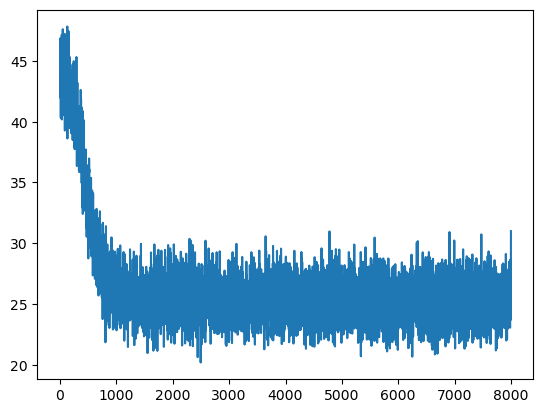

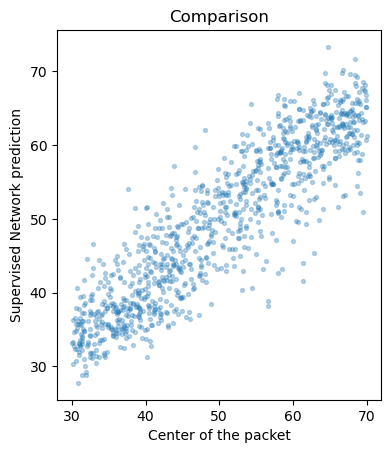

In [75]:
superv_show_perf(supervised_qm, f.qm_j, s_qm_net.history)

### PCA

In [76]:
# Perform PCA on a large sample
# PCA feature will then only be applied on new samples
# (and not calculated on the mini-batch)
big_batch = get_batch(100000)[0]
pca = PCA(big_batch,1)

In [77]:
supervised_pca = new_supervised_net(neurons_supervised, eta_supervised)
s_pca_net = nn.Net(supervised_pca,
                   mode="a",
                   path = "models/wavepacket-sup-pca")

Loaded neural network weights from models/wavepacket-sup-pca


In [78]:
s_pca_net.fit_generator(lambda: get_superv_batch(N_batch, lambda samples: (pca.transform(samples),None)), N_train_supervised)

Model already trained, skipping training.


[15.3597993850708]


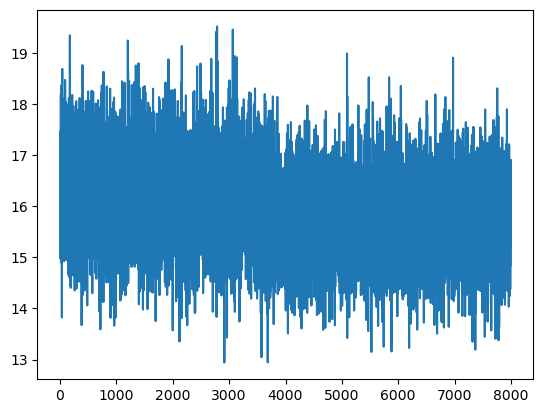

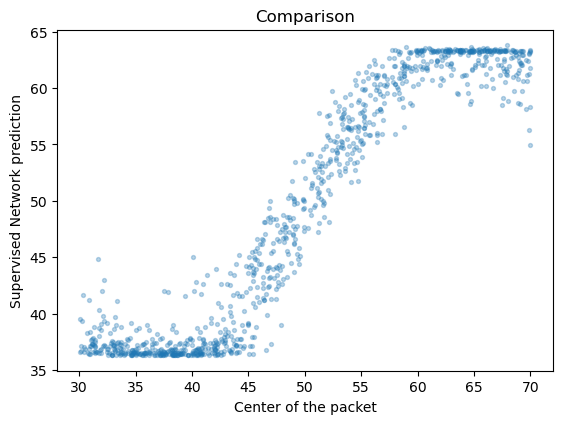

In [79]:
superv_show_perf(supervised_pca, f.pca, s_pca_net.history)

### Autoencoder

In [80]:
supervised_ae = new_supervised_net(neurons_supervised, eta_supervised)
s_ae_net = nn.Net(supervised_ae,
                  mode="a",
                  path = "models/wavepacket-sup-ae")

Loaded neural network weights from models/wavepacket-sup-ae


In [81]:
s_ae_net.fit_generator(lambda: get_superv_batch(N_batch, enc_net.get_feature_and_grad), N_train_supervised)

Model already trained, skipping training.


[1.1280921697616577]


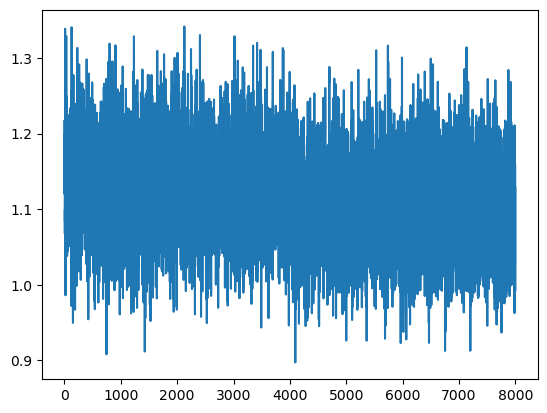

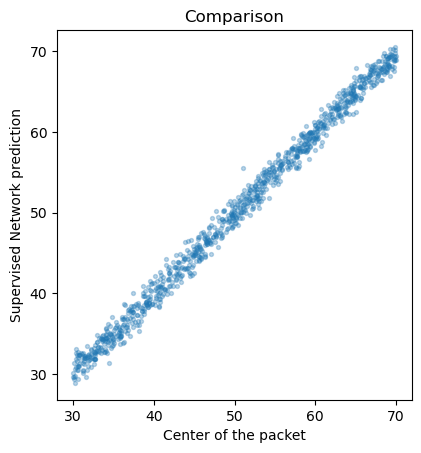

In [82]:
superv_show_perf(supervised_ae, enc_net.get_feature_and_grad, s_ae_net.history)

---

### Compare the results

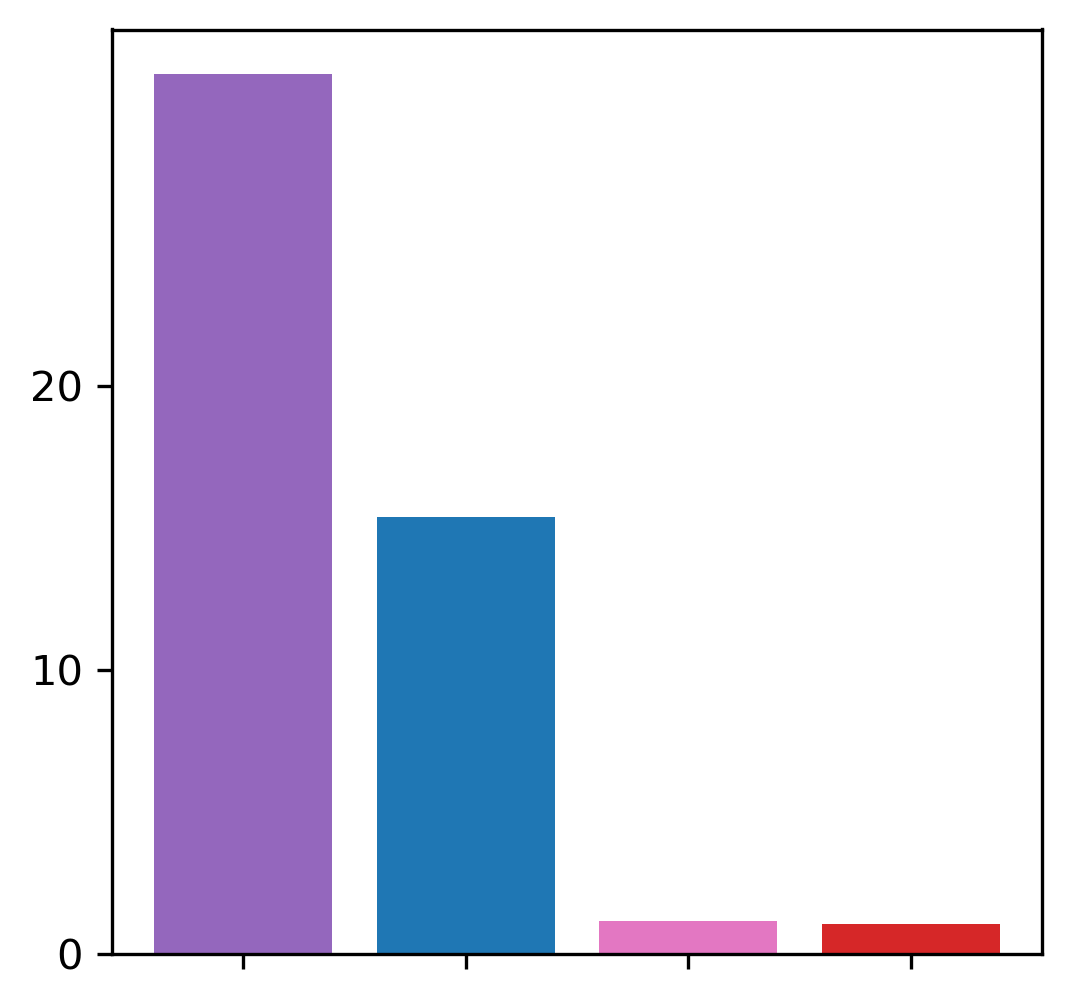

In [83]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cols = prop_cycle.by_key()['color']

plt.figure(figsize=[4,4], dpi=300)
plt.bar(np.array(np.arange(4)),
        np.array([
            s_qm_net.history[-1][0],
            s_pca_net.history[-1][0],
            s_ae_net.history[-1][0],
            s_rmi_net.history[-1][0]]), 
        tick_label="", 
        color=[cols[4], cols[0],cols[6] ,cols[3]]
       )

font = {'family': 'DejaVu Serif',
        'weight': 'regular',
        'size': 22}
plt.rc('font', **font)
plt.yticks([20,10,0], ["20","10","0"])
plt.savefig("figures/wp-supervised.pdf")
plt.show()

In [51]:
# Summary table
def format_bar(val,max_val=s_qm_net.history[-1][0],length=28):
    return "{empty:#^{val}}".format(empty="",val=int(val/max_val*length))

print("")
print("\t|{:-^56}|".format(""))
print("\t|{:^56}|".format(" Final Cost - Supervised Task "))
print("\t|{:=^56}|".format(""))
print("\t|{:>15}{:^12.2f}{:.<28} |".format("QM:", s_qm_net.history[-1][0],format_bar(s_qm_net.history[-1][0])))
print("\t|{:>15}{:^12.2f}{:.<28} |".format("PCA:", s_pca_net.history[-1][0],format_bar(s_pca_net.history[-1][0])))
print("\t|{:>15}{:^12.2f}{:.<28} |".format("AE:", s_ae_net.history[-1][0],format_bar(s_ae_net.history[-1][0])))
print("\t|{:>15}{:^12.2f}{:.<28} |".format("NN:", s_rmi_net.history[-1][0],format_bar(s_rmi_net.history[-1][0])))
print("\t|{:-^56}|".format(""))
print("")



	|--------------------------------------------------------|
	|              Final Cost - Supervised Task              |
	|========================================================|
	|            QM:   31.00    ############################ |
	|           PCA:   15.36    #############............... |
	|            AE:    1.13    #........................... |
	|            NN:    1.05    ............................ |
	|--------------------------------------------------------|



Plot value of supervised cost function during training


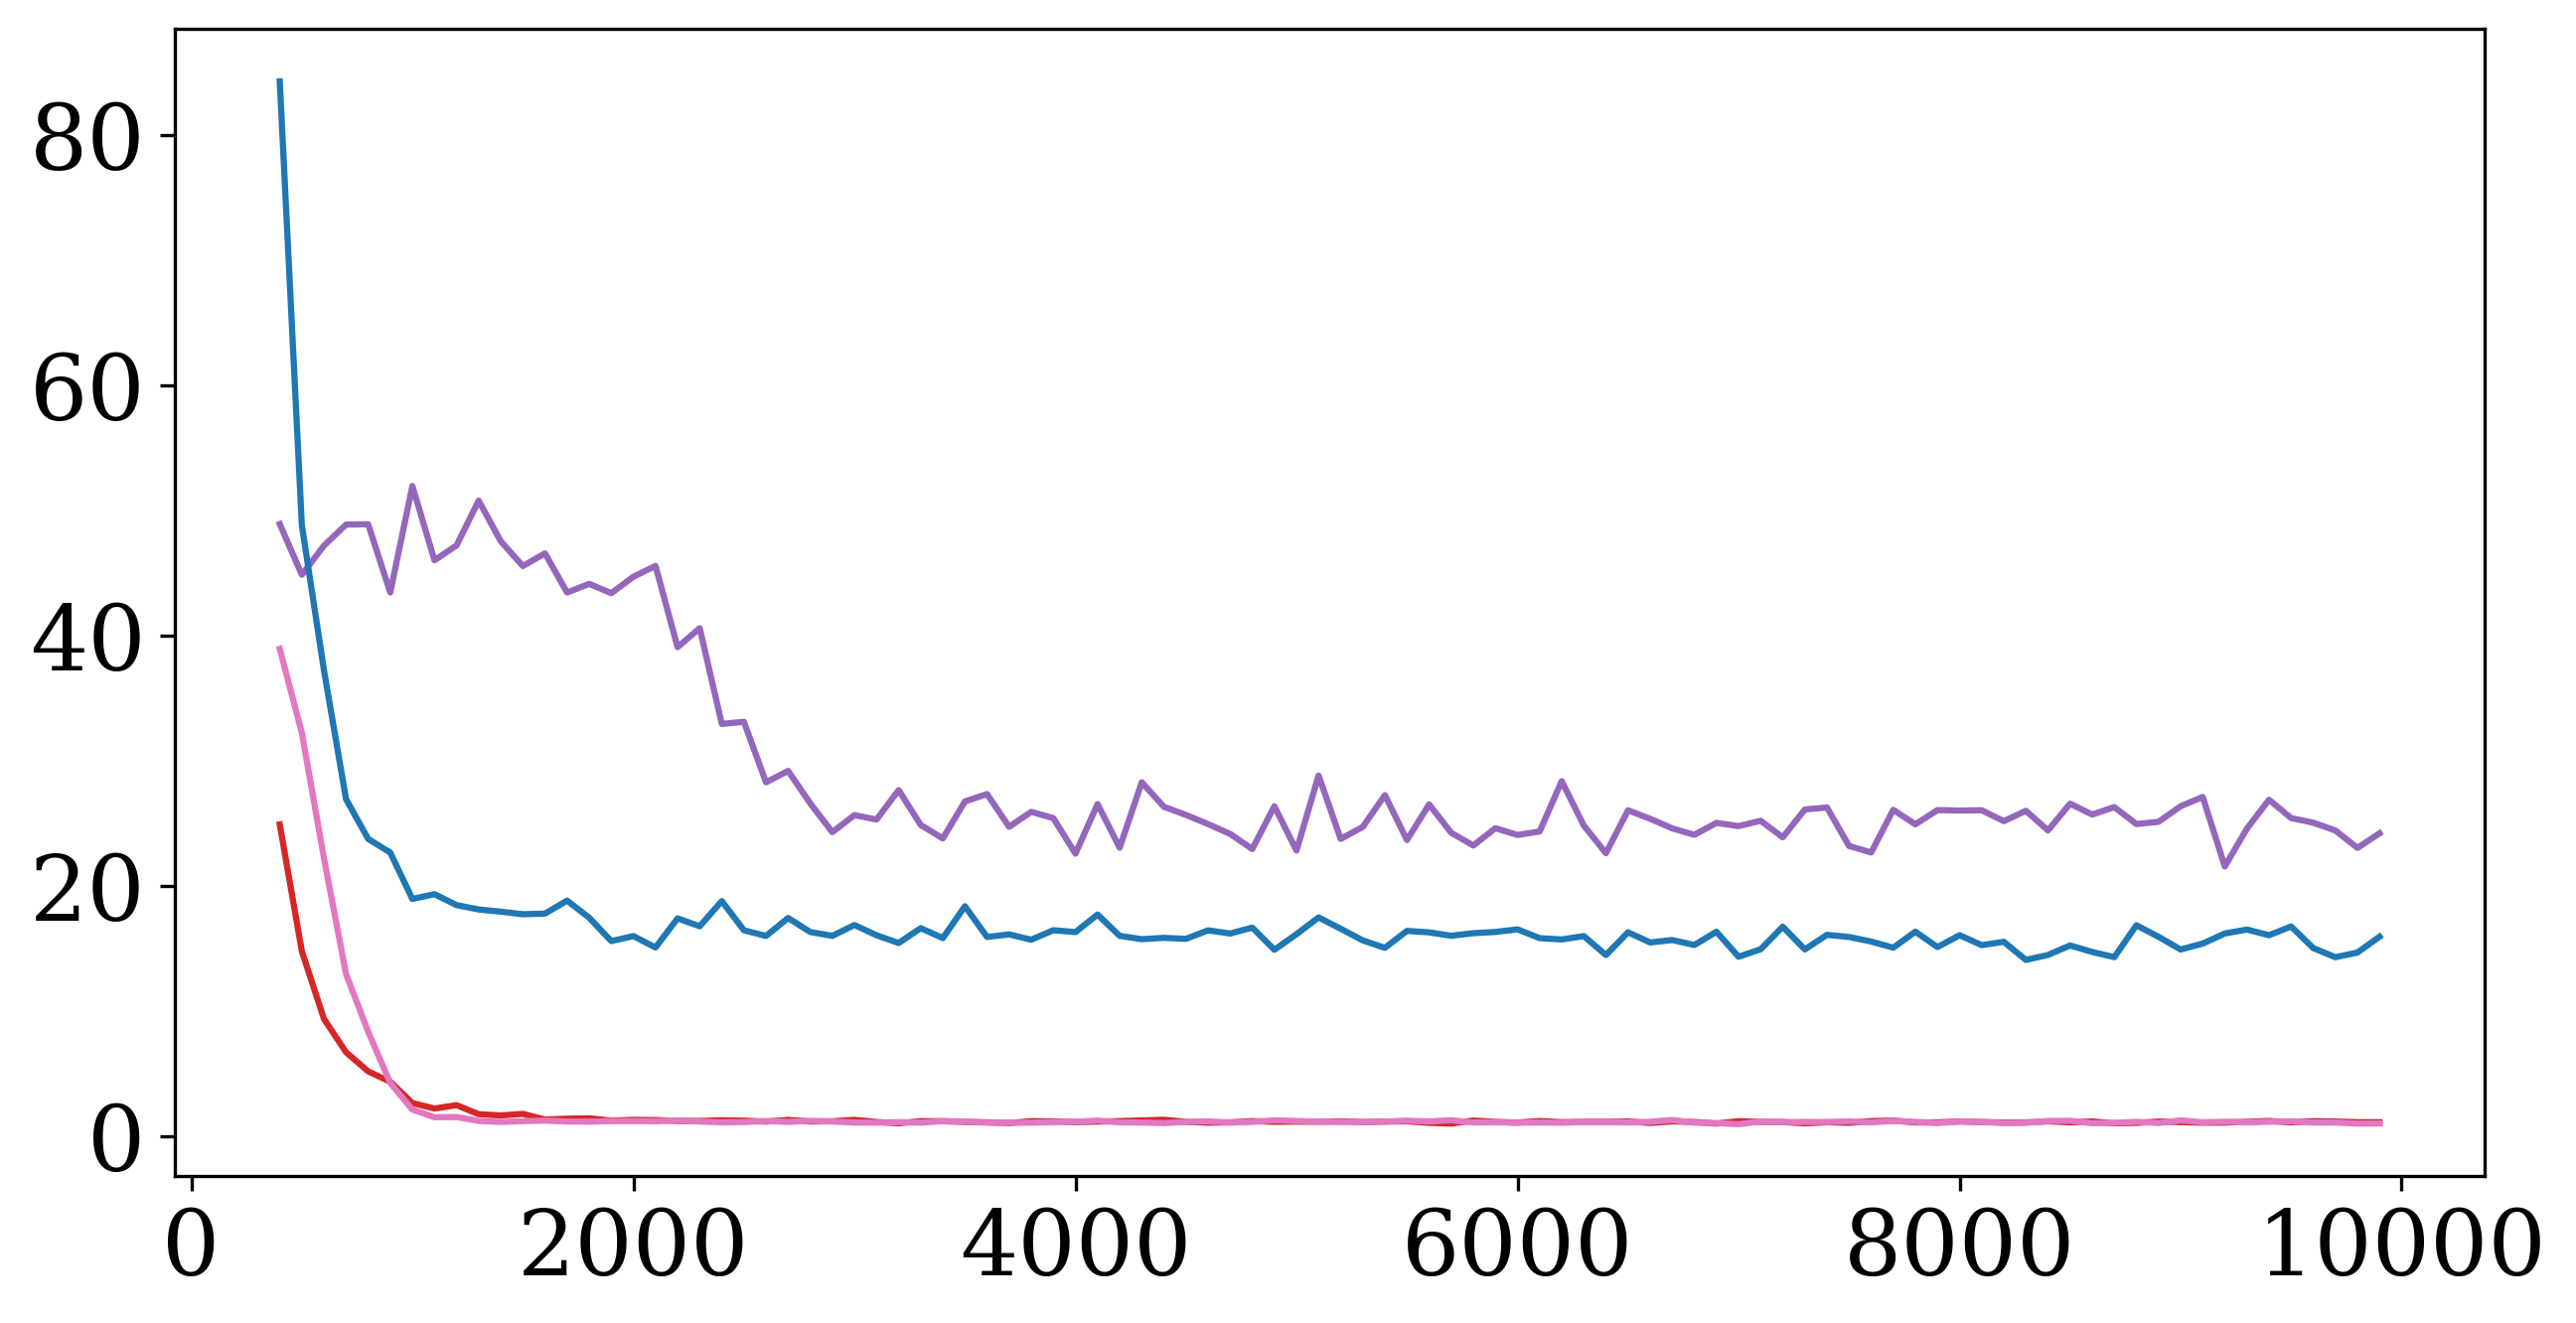

In [52]:
start = 400
skip = 100
plt.figure(figsize=[10,5],dpi=300)
# plt.title("Training supervised task")
# plt.xlabel("Training step")
# plt.ylabel("Cost")
hst = np.transpose(s_rmi_net.history)
hst = np.vstack([np.arange(len(hst.T)),hst])
plt.plot(hst[0,start::skip],hst[1,start::skip], label="NN", c=cols[3])

hst = np.transpose(s_qm_net.history)
hst = np.vstack([np.arange(len(hst.T)),hst])
plt.plot(hst[0,start::skip],hst[1,start::skip],label="QM", c=cols[4])

hst = np.transpose(s_pca_net.history)
hst = np.vstack([np.arange(len(hst.T)),hst])
plt.plot(hst[0,start::skip],hst[1,start::skip],label="PCA", c=cols[0])

hst = np.transpose(s_ae_net.history)
hst = np.vstack([np.arange(len(hst.T)),hst])
plt.plot(hst[0,start::skip],hst[1,start::skip],label="AE", c=cols[6])

# plt.legend()
plt.savefig("figures/wave-packet-supervised-comparison.pdf")
plt.show()

### Simple analysis

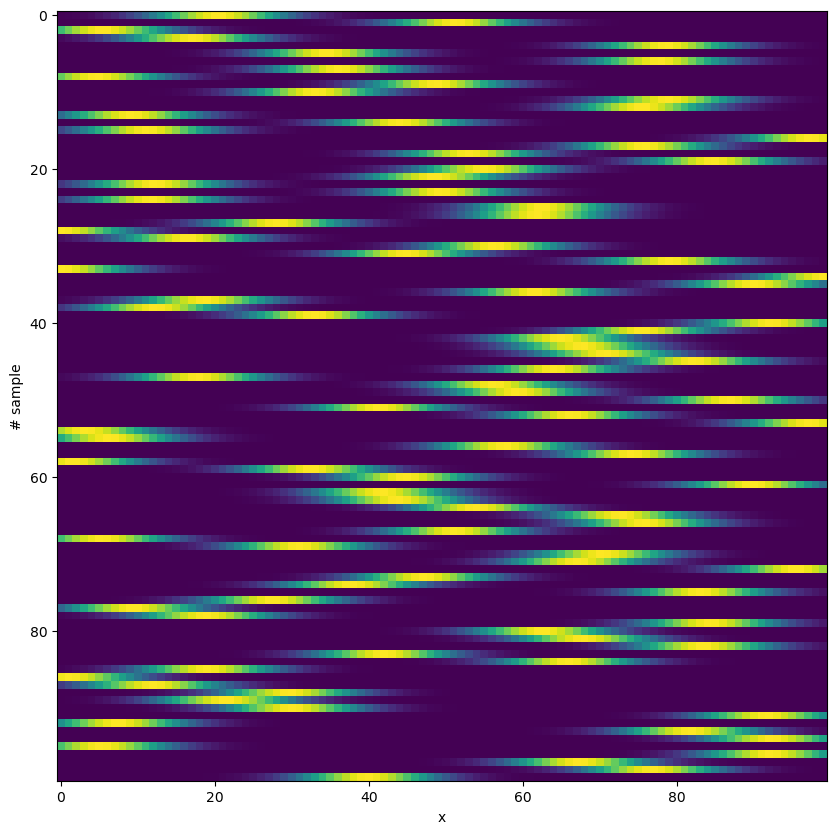

Feature              MI       H     MI-H
cm                   -3.05  -5.35  +2.30
sum(x[j])            -3.05  -0.74  -2.30
sum(j x[j])          +0.75  +7.10  -6.35
sum(j x[j]**2)       +1.27  +6.83  -5.56
<x|j|x>              +3.54  +4.50  -0.96
PCA                  +1.10  +1.10  +0.00


In [58]:
Samples, last_pos = wp.produce_Wave_Packet(n_pixels=100,n_samples=10000,width=9.0)
wp.plot(Samples)

# Example usage of the Information module:
# - Calculate the feature and its gradient
feature_and_grad = f.sum_x2_j(Samples)

# - Calculate the probability distribution of the feature
P = inf.produce_P(feature_and_grad[0])

# - Calculate the Entropy of the feature distribution
H = inf.Entropy(*P)

# - Calculate Renormalized Mutual information
inf.RenormalizedMutualInformation(*feature_and_grad)

# - Calculate and compare Renormalized Mutual Information and Entropy for a given list of features 
#   (functions that return the value of the feature and its gradient)
inf.print_feature_batch(Samples,
                        [f.cm, f.sum_x, f.sum_x_j, f.sum_x2_j, f.qm_j, f.pca], 
                        ["cm","sum(x[j])" ,"sum(j x[j])", "sum(j x[j]**2)", "<x|j|x>",  "PCA"]);

In [61]:
# N_pixels=100
# Samples, last_pos = wp.produce_Wave_Packet(n_pixels=N_pixels,n_samples=200,width=width,noise=0.2,pos_range=pos_range)
# wp.plot(Samples)

# js=np.array(range(n_in))
# for i in range(3):
#     print(i)
#     plt.figure(figsize=(4,2),dpi=300)
#     plt.scatter(js,wp.last_background[i,:],s=16, c="blue")
#     plt.axis('off')
#     plt.savefig("figures/wp_noise" + str(i)+".pdf")
#     plt.show()

#     plt.figure(figsize=(4,2),dpi=300)
#     plt.scatter(js,wp.last_wp[i,:],s=16,c="blue")
#     plt.axis('off')
#     plt.savefig("figures/wp_shape" + str(i)+".pdf")
#     plt.show()

#     plt.figure(figsize=(4,2),dpi=300)
#     plt.scatter(js,Samples[i,:],s=16, c="blue")
#     plt.axis('off')
#     plt.savefig("figures/wp_all" + str(i)+".pdf")
#     plt.show()